In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:24<00:00,  4.65it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 52.55it/s]

Done!


In [4]:
#Convert the data to float and scale the values between 0 to 1.
# Change to float datatype
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
 
# Scale the data to lie between 0 to 1
X_train /= 255
Y_train /= 255

print X_train.shape
print Y_train.shape
print X_test.shape

(670, 256, 256, 3)
(670, 256, 256, 1)
(65, 256, 256, 3)


In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = 'adam'
loss      = 'binary_crossentropy'
metrics   = ['accuracy']

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256, 256, 64)      256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
dense_8 (Dense)              (None, 256, 256, 64)      4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
dense_9 (Dense)              (None, 256, 256, 1)       65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [20]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-sol-5-mlp-best.h5', verbose=1, save_best_only=True)

In [21]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=20, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 162s 269ms/step - loss: 0.4870 - acc: 0.8449 - val_loss: 0.2891 - val_acc: 0.8622

Epoch 00001: val_loss improved from inf to 0.28915, saving model to model-sol-5-mlp-best.h5
Epoch 2/20
603/603 [==============================] - 150s 249ms/step - loss: 0.1583 - acc: 0.8474 - val_loss: 0.0553 - val_acc: 0.8622

Epoch 00002: val_loss improved from 0.28915 to 0.05527, saving model to model-sol-5-mlp-best.h5
Epoch 3/20
603/603 [==============================] - 152s 253ms/step - loss: 0.0377 - acc: 0.8474 - val_loss: 0.0171 - val_acc: 0.8622

Epoch 00003: val_loss improved from 0.05527 to 0.01712, saving model to model-sol-5-mlp-best.h5
Epoch 4/20
603/603 [==============================] - 152s 252ms/step - loss: 0.0174 - acc: 0.8474 - val_loss: 0.0101 - val_acc: 0.8622

Epoch 00004: val_loss improved from 0.01712 to 0.01014, saving model to model-sol-5-mlp-best.h5
Epoch 5/20
603/603 [=======

KeyboardInterrupt: 

In [22]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [23]:
model = load_model('model-sol-5-mlp-best.h5', custom_objects={'mean_iou': mean_iou})

preds_test = model.predict(X_test, verbose=1)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 3s 43ms/step


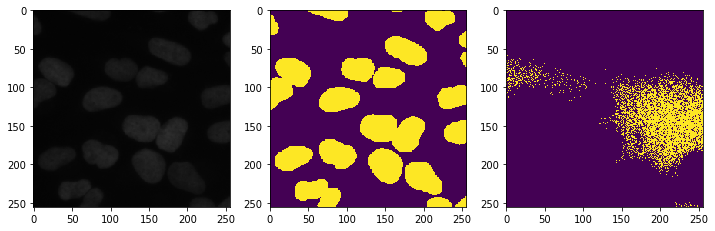

In [24]:
# Display some random training samples
ix = random.randint(0, len(preds_test))

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(X_train[ix])
plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_test[ix]))
plt.show()

In [32]:
def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n], 0.0001))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sol-5-mlp-sub.csv', index=False)

print sub.shape[0]

2742
